# Fast BBH analysis

This notebooks demonstrates analysing a subset of the standard BBH parameters using the importance nested sampler in nessai.

This example is based on [`fast_tutorial.py`](https://git.ligo.org/lscsoft/bilby/-/blob/master/examples/gw_examples/injection_examples/
fast_tutorial.py) in `bilby`.

## Installation

We need to install bleeding edge versions of `bilby` and `nessai` to use the importance nested sampler in `bilby`.

**Warning:** these versions of the packages are bleeding edge and subject to changes.

In [1]:
!pip install git+https://github.com/mj-will/nessai.git@stable-ins --no-deps
!pip install git+https://git.ligo.org/michael.williams/bilby.git@nessai-update-for-ins --no-deps --force

  Cloning https://github.com/mj-will/nessai.git (to revision stable-ins) to /tmp/pip-req-build-o8qtabg5
  Running command git clone -q https://github.com/mj-will/nessai.git /tmp/pip-req-build-o8qtabg5
  Running command git checkout -b stable-ins --track origin/stable-ins
  Switched to a new branch 'stable-ins'
  Branch 'stable-ins' set up to track remote branch 'stable-ins' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://git.ligo.org/michael.williams/bilby.git (to revision nessai-update-for-ins) to /tmp/pip-req-build-g90pl8nv
  Running command git clone -q https://git.ligo.org/michael.williams/bilby.git /tmp/pip-req-build-g90pl8nv
  Running command git checkout -b nessai-update-for-ins --track origin/nessai-update-for-ins
  Switched to a new branch 'nessai-update-for-ins'
  Branch 'nessai-update-for-ins' set up to track remote branch 'nessai-update-for-ins' from 'origin'.
  Cr

## Setup

In [2]:
import bilby
import numpy as np

In [3]:
duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

outdir = "outdir"
label = "gw_ins_nessai"
bilby.core.utils.setup_logger(outdir=outdir, label=label)


## Likelihood

This example uses a GW150914-like injection in a three-detector network.

In [1]:
# GW150914-like injection
injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=2000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)


In [ ]:

# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up a three-detector network.
ifos = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)
ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)

likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=waveform_generator
)




## Priors

We then define the priors and fix a number of the parameters

In [5]:
priors = bilby.gw.prior.BBHPriorDict()
for key in [
    "a_1",
    "a_2",
    "tilt_1",
    "tilt_2",
    "phi_12",
    "phi_jl",
    "psi",
    "ra",
    "dec",
    "geocent_time",
    "phase",
]:
    priors[key] = injection_parameters[key]

# Perform a check that the prior does not extend to a parameter space longer than the data
priors.validate_prior(duration, minimum_frequency)

# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveform generator


12:03 bilby INFO    : No prior given, using default BBH priors in /home/michaelwilliams/.miniconda3/envs/nessai/lib/python3.8/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [6]:

# Run sampler.  In this case we're going to use the `dynesty` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nessai_importance",
    nlive=1000,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    clean=True,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
)


12:03 bilby INFO    : Running for label 'gw_ins_nessai', output will be saved to 'outdir'
12:03 bilby INFO    : Using lal version 7.1.7
12:03 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
12:03 bilby INFO    : Using lalsimulation version 3.1.2
12:03 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
12:03 bilby INFO    : Search parameters:
12:03 bilby INFO    :   mass_ratio = bilby.gw.prior.UniformInComponentsMassRatio(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
12:03 bilby INFO    :   chirp_mass = bilby.gw.prior.UniformInComponentsChirpMass(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
12:03 bilby

100%|██████████| 2966/2966 [00:00<00:00, 4393.54it/s]

12:07 bilby INFO    : Computing SNRs for every sample.



100%|██████████| 2966/2966 [00:10<00:00, 288.98it/s]


12:07 bilby INFO    : Summary of results:
nsamples: 2966
ln_noise_evidence: -12256.379
ln_evidence: -12123.053 +/-  0.017
ln_bayes_factor: 133.326 +/-  0.017



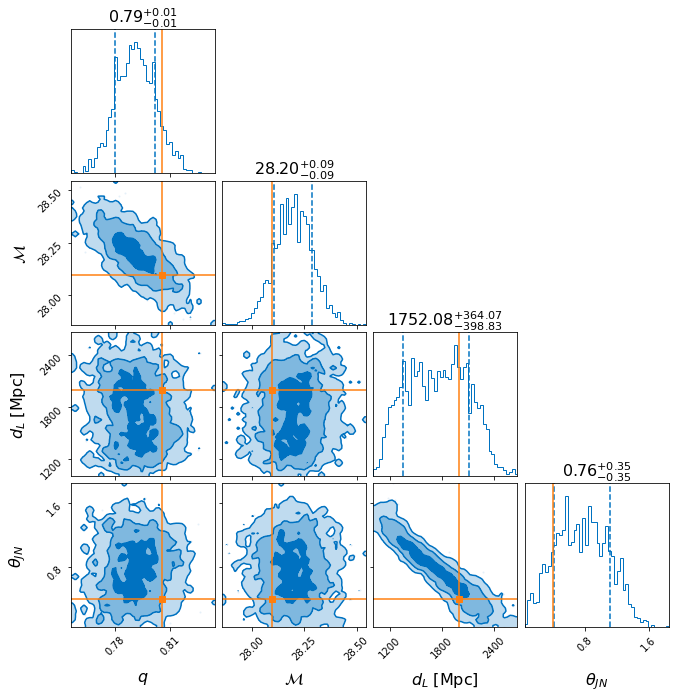

In [7]:
result.plot_corner()